In [1]:
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torchvision.transforms.functional as TF
from einops import rearrange
from kornia.geometry import ImageRegistrator, homography_warp
from skimage.color import label2rgb



In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.utils as utils
from mushroom.models.expression_prediction import STExpressionLightning
from mushroom.learners import HEExpressionPredictor, STExpressionLearner

In [5]:
fps = sorted(utils.listfiles('/data/estorrs/mushroom/data/runs/HT397B1_v1/expression_prediction/run_1/predictions/',
                             regex=r'masks.pt$'))
fps

['/data/estorrs/mushroom/data/runs/HT397B1_v1/expression_prediction/run_1/predictions/HT397B1-S1H3A1U1_masks.pt',
 '/data/estorrs/mushroom/data/runs/HT397B1_v1/expression_prediction/run_1/predictions/HT397B1-S1H3A1U21_masks.pt']

In [7]:
sid_to_masks_exp = {}
genes = None
for fp in fps:
    sid = re.sub(r'^.*/(.*)_masks.pt', r'\1', fp)
    d = torch.load(fp)
    sid_to_masks_exp[sid] = torch.tensor(d['masks'], dtype=torch.bool)
    genes = d['genes']
sid_to_masks_exp.keys(), genes

/tmp/ipykernel_4108616/4106114602.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sid_to_masks_exp[sid] = torch.tensor(d['masks'], dtype=torch.bool)


(dict_keys(['HT397B1-S1H3A1U1', 'HT397B1-S1H3A1U21']),
 ['IL7R', 'EPCAM', 'ACTA2'])

In [12]:
# bbox = (300,1800,200,1700)

# sid_to_masks = {k:v[:, bbox[0]:bbox[1], bbox[2]:bbox[3]] for k, v in sid_to_masks.items()}

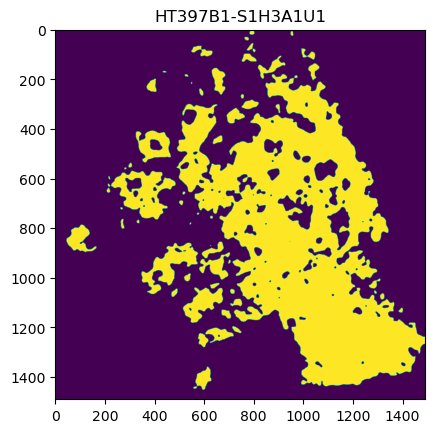

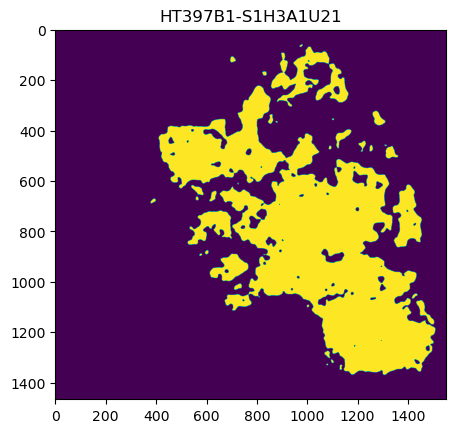

In [8]:
for k, v in sid_to_masks_exp.items():
    plt.imshow(v[2])
    plt.title(k)
    plt.show()

In [9]:
def labeled_image_from_masks(masks, order=None):
    if order is None:
        order = np.arange(masks.shape[0])
    new = torch.zeros((masks.shape[-2], masks.shape[-1]), dtype=torch.long)
    count = 1
    for i in order:
        new[masks[i]] = count
        count += 1
    return new

In [10]:
order = ['ACTA2', 'IL7R', 'EPCAM']
# order = ['EPCAM']
order_idxs = [genes.index(g) for g in order]
sid_to_labeled_exp = {k:labeled_image_from_masks(v, order=order_idxs)
                  for k, v in sid_to_masks_exp.items()}

In [11]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

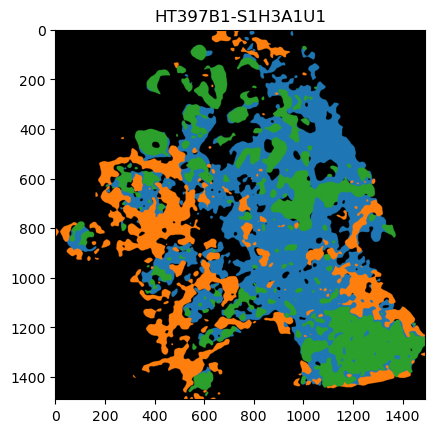

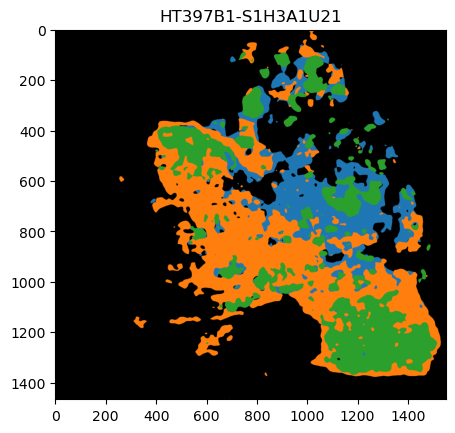

In [12]:
for k, v in sid_to_labeled_exp.items():
    plt.imshow(label2rgb(v.numpy(), colors=sns.color_palette()))
    plt.title(k)
    plt.show()

In [13]:
## codex here

In [14]:
fps = sorted(utils.listfiles('/data/multiplex_imaging/codex/htan/brca', regex=r'ome.tiff$'))
fps

['/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff']

In [15]:
sid_to_fp = {
    'HT397B1-S1H3A1U2': '/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
    'HT397B1-S1H3A1U12': '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff'
}

In [16]:
for sid, fp in sid_to_fp.items():
    print(sid, utils.get_ome_tiff_channels(fp))

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


HT397B1-S1H3A1U2 ['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin', 'CD68 (D)', 'HLA-DR', 'Keratin 14', 'FoxP3', 'MGP-(D)', 'CD20-(D)', 'SMA-(D)', 'Ki67', 'Vimentin-(D)', 'PR-(D)', 'Bap1 (D)', 'CD45 (D)', 'ER', 'CD31', 'COX6c (D)', 'CK19', 'PLAT/tPA (D)']
HT397B1-S1H3A1U12 ['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin', 'CD68 (D)', 'HLA-DR', 'Keratin 14', 'FoxP3', 'MGP-(D)', 'CD20-(D)', 'SMA-(D)', 'Ki67', 'Vimentin-(D)', 'PR-(D)', 'Bap1 (D)', 'CD45 (D)', 'ER', 'CD31', 'COX6c (D)', 'CK19', 'PLAT/tPA (D)']


In [17]:
order

['ACTA2', 'IL7R', 'EPCAM']

In [18]:
channels = ['SMA-(D)', 'CD45 (D)', 'Pan-Cytokeratin']
sid_to_ome = {}
for k, fp in sid_to_fp.items():
    print(k)
    d = utils.extract_ome_tiff(fp, channels=channels)
    sid_to_ome[k] = {k:torch.tensor(v) for k, v in d.items()}

HT397B1-S1H3A1U2
HT397B1-S1H3A1U12


In [19]:
def preprocess_multiplex(img, scale=.1):
    if not isinstance(img, torch.Tensor):
        img = torch.tensor(img)
    if len(img.shape) == 2:
        img = img.unsqueeze(0)
    subsampled = TF.resize(img, (int(img.shape[-2] * scale), int(img.shape[-1] * scale))).to(torch.float32)
    subsampled = TF.gaussian_blur(subsampled, 43)
    subsampled -= rearrange(rearrange(subsampled, 'c h w -> c (h w)').min(dim=1).values, 'b -> b 1 1')
    subsampled /= rearrange(rearrange(subsampled, 'c h w -> c (h w)').max(dim=1).values, 'b -> b 1 1')
    return subsampled

In [20]:
sid_to_processed = {sid:{k:preprocess_multiplex(v) for k, v in d.items()}
                   for sid, d in sid_to_ome.items()}

In [21]:
sid, d = next(iter(sid_to_processed.items()))
sid

'HT397B1-S1H3A1U2'

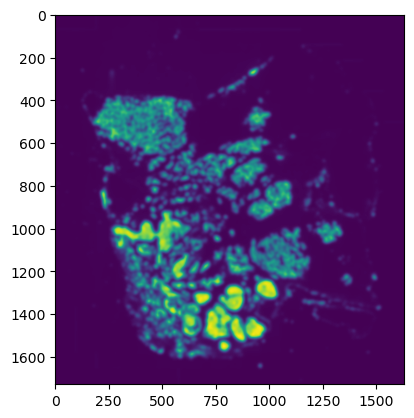

In [22]:
plt.imshow(d['Pan-Cytokeratin'][0])

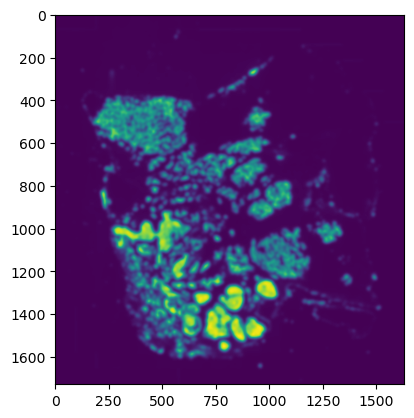

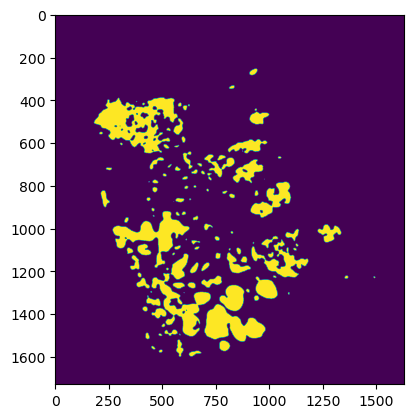

In [23]:
gene = 'Pan-Cytokeratin'
cut = .4
plt.imshow(d[gene][0])
plt.show()
plt.imshow(d[gene][0]>cut)
plt.show()

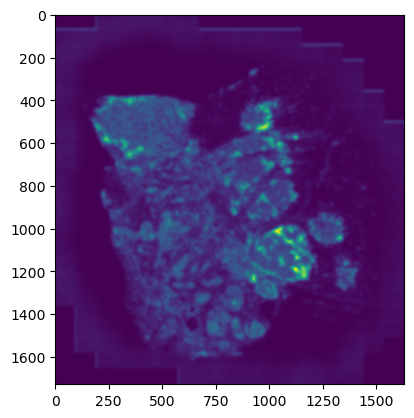

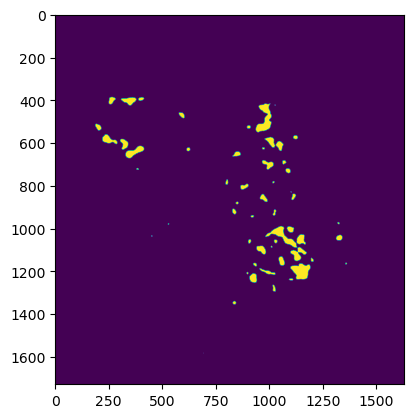

In [24]:
gene = 'CD45 (D)'
cut = .4
plt.imshow(d[gene][0])
plt.show()
plt.imshow(d[gene][0]>cut)
plt.show()

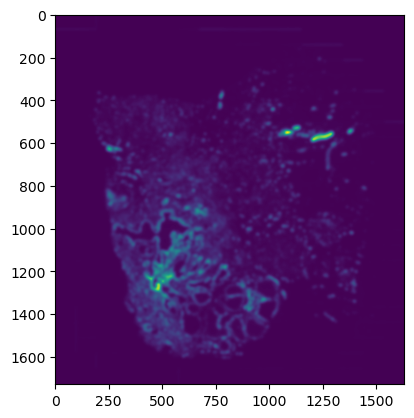

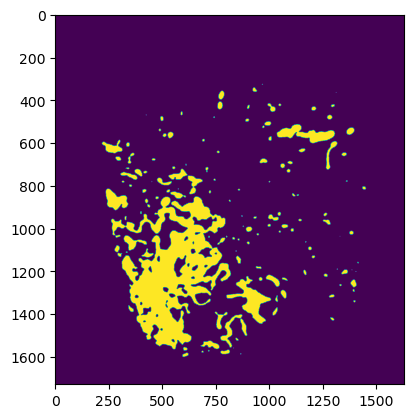

In [25]:
gene = 'SMA-(D)'
cut = .1
plt.imshow(d[gene][0])
plt.show()
plt.imshow(d[gene][0]>cut)
plt.show()

In [39]:
cuts = {
    'Pan-Cytokeratin': .3,
    'CD45 (D)': .3,
    'SMA-(D)': .05
}
sid_to_masks_codex = {}
for sid, d in sid_to_processed.items():
    new = torch.zeros((len(cuts), d[channels[0]].shape[-2], d[channels[0]].shape[-1]), dtype=torch.bool)
    for i, c in enumerate(channels):
        new[i] = d[c] > cuts[c]
    sid_to_masks_codex[sid] = new

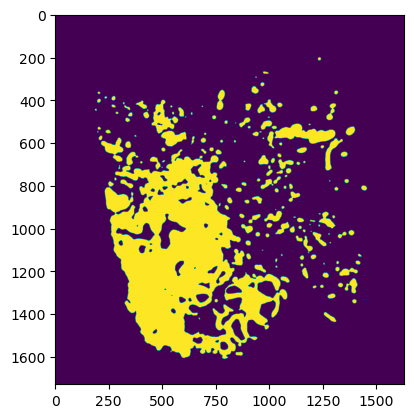

In [40]:
plt.imshow(next(iter(sid_to_masks_codex.values()))[0])

In [41]:
sid_to_labeled_codex = {k:labeled_image_from_masks(v, order=np.arange(len(channels)))
                  for k, v in sid_to_masks_codex.items()}

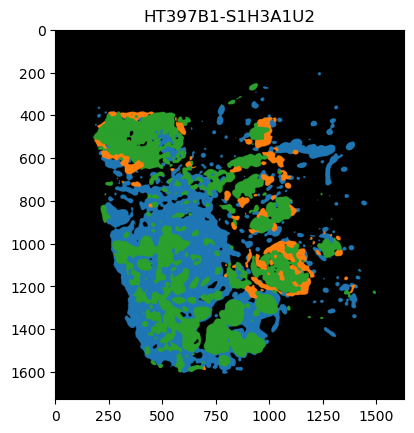

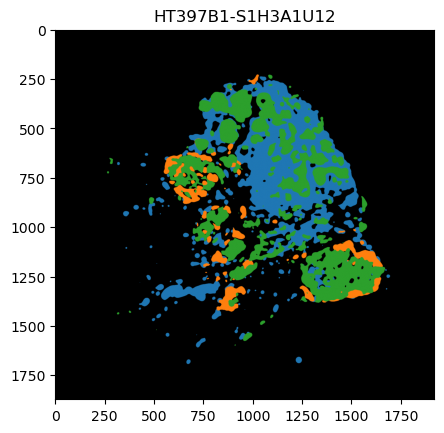

In [42]:
for k, v in sid_to_labeled_codex.items():
    plt.imshow(label2rgb(v.numpy(), colors=sns.color_palette()))
    plt.title(k)
    plt.show()

In [43]:
sid_to_labeled_codex.keys(), sid_to_labeled_exp.keys()

(dict_keys(['HT397B1-S1H3A1U2', 'HT397B1-S1H3A1U12']),
 dict_keys(['HT397B1-S1H3A1U1', 'HT397B1-S1H3A1U21']))

In [44]:
sid_to_labeled = sid_to_labeled_exp.copy()
sid_to_labeled.update(sid_to_labeled_codex)
sid_to_labeled.keys()

dict_keys(['HT397B1-S1H3A1U1', 'HT397B1-S1H3A1U21', 'HT397B1-S1H3A1U2', 'HT397B1-S1H3A1U12'])

In [45]:
def preprocess_labeled_images(imgs, scale=.1):
    transformed = []
    for img in imgs:
        img = img.to(torch.float32)
        img /= img.max()
        img = TF.resize(rearrange(img, 'h w -> 1 1 h w'), (int(img.shape[-2] * scale), int(img.shape[-1] * scale)))
        transformed.append(img)
        
    max_h = max([img.shape[-2] for img in transformed])
    max_w = max([img.shape[-1] for img in transformed])
    
    transformed = [TF.pad(img, (0, 0, max_w - img.shape[-1], max_h - img.shape[-2]), padding_mode='constant')
                  for img in transformed]
        
    return transformed

In [46]:
sample_order = ['HT397B1-S1H3A1U1', 'HT397B1-S1H3A1U2', 'HT397B1-S1H3A1U12', 'HT397B1-S1H3A1U21']
transformed = preprocess_labeled_images([sid_to_labeled[sid] for sid in sample_order])
sid_to_img = {sid:img for sid, img in zip(sample_order, transformed)}

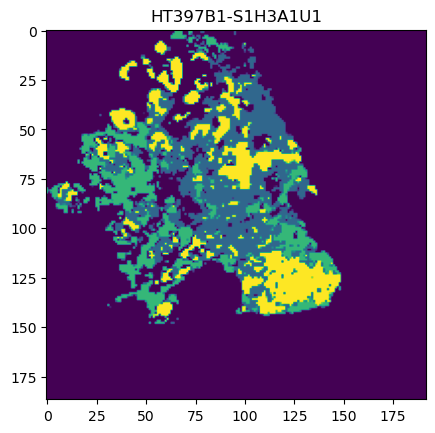

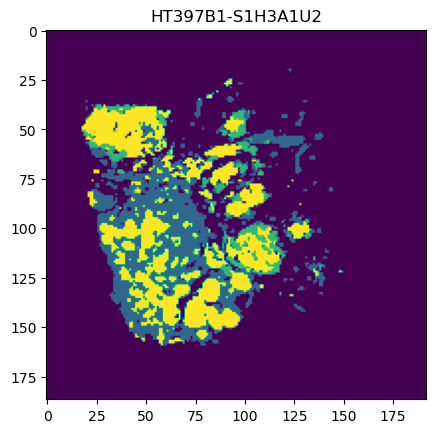

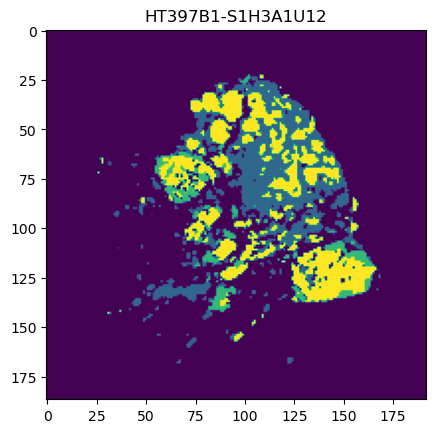

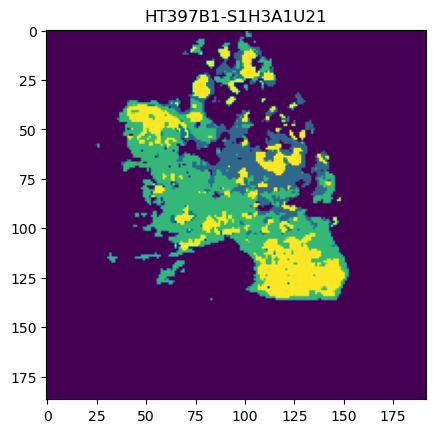

In [47]:
for k, v in sid_to_img.items():
    plt.imshow(v[0, 0])
    plt.title(k)
    plt.show()

In [62]:
rotations = {
    'HT397B1-S1H3A1U2': 180
}

for k, v in sid_to_img.items():
    if k in rotations:
        sid_to_img[k] = TF.rotate(v, rotations[k])

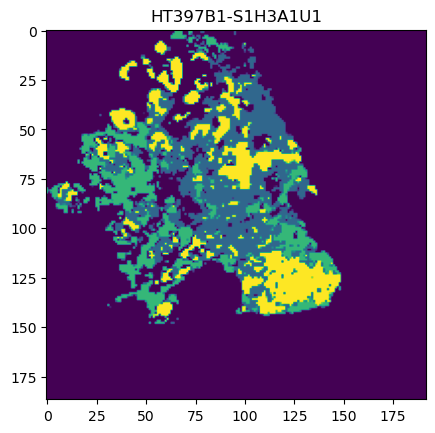

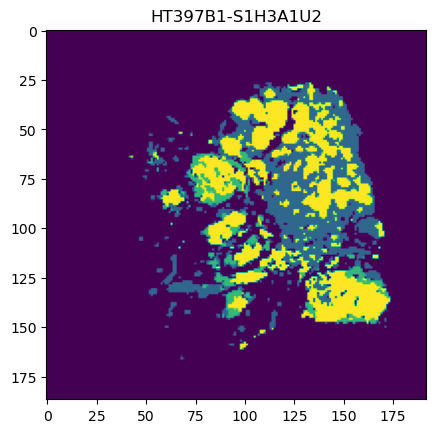

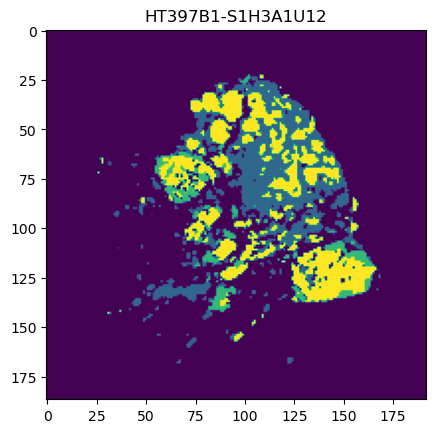

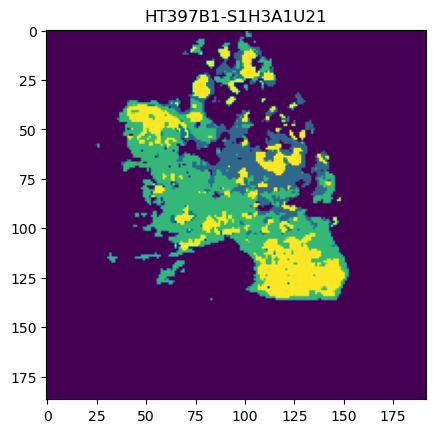

In [63]:
for k, v in sid_to_img.items():
    plt.imshow(v[0, 0])
    plt.title(k)
    plt.show()

In [64]:
slices = [sid_to_img[sid] for sid in sample_order]
# slices = slices[::-1]
len(slices)

4

In [65]:
def register_image(img1, img2):
    registrator = ImageRegistrator('similarity')
    x = registrator.register(img1, img2)
    w = homography_warp(img1, x, img2.shape[-2:])
    return {
        'transform': x,
        'warped': w,
        'moving': img1,
        'fixed': img2
    }

In [66]:
results = []
for i in range(len(slices)-1):
    print(i, i+1)
    moving, fixed = slices[i], slices[i+1]
    result = register_image(moving, fixed)
    results.append(result)

0 1
1 2
2 3


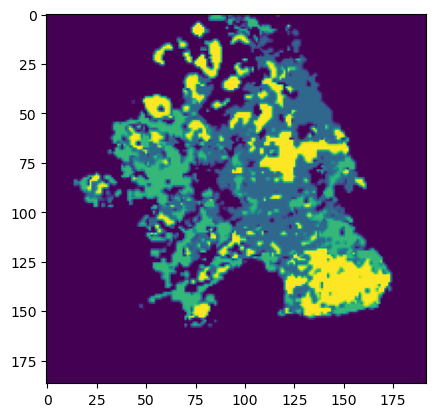

In [67]:
plt.imshow(results[0]['warped'][0, 0].detach())

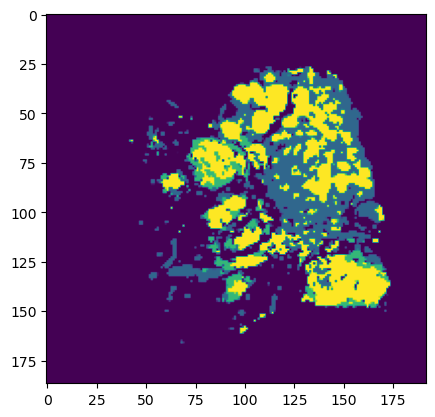

In [68]:
plt.imshow(results[0]['fixed'][0, 0].detach())

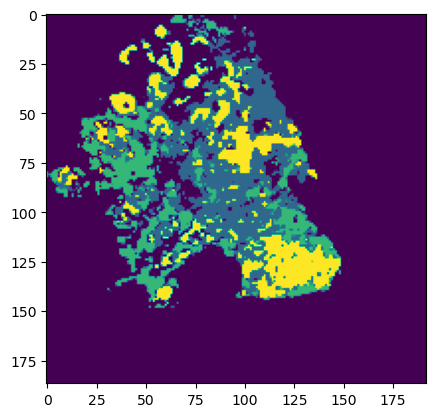

In [69]:
plt.imshow(results[0]['moving'][0, 0].detach())

In [138]:
registrator = ImageRegistrator('similarity')

In [139]:
x = registrator.register(slices[0], slices[1])

In [140]:
w = homography_warp(slices[0], x, slices[1].shape[-2:])
w.shape

torch.Size([1, 1, 149, 155])

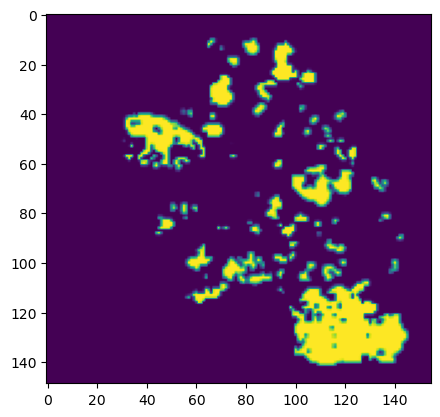

In [141]:
plt.imshow(w[0, 0].detach().numpy())

In [35]:
x

tensor([[[ 1.0362, -0.0053, -0.2634],
         [ 0.0053,  1.0362,  0.1698],
         [ 0.0000,  0.0000,  1.0000]]], grad_fn=<CopySlices>)

In [ ]:
from kornia.geometry import ImageRegistrator
img_src = torch.rand(1, 1, 32, 32)
img_dst = torch.rand(1, 1, 32, 32)
registrator = ImageRegistrator('similarity')
homo = registrator.register(img_src, img_dst)